In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import Normalizer,StandardScaler , PowerTransformer, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer#IterativeImputer
from category_encoders import TargetEncoder, BinaryEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, KFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn import set_config
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.experimental import enable_iterative_imputer  
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingClassifier, StackingRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

import optuna
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution
from optuna.integration import OptunaSearchCV, ShapleyImportanceEvaluator
from optuna.visualization import plot_param_importances
import re
import feature_engine as fe
import category_encoders as ce

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
#nltk.download('punkt')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


#from catboost import CatBoostRegressor



pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
park_df = pd.read_csv('data/park.csv')
care_df = pd.read_csv('data/day_care_center.csv')
submission_df = pd.read_csv('data/submission.csv')


se_subway = pd.read_csv('data/서울지하철.csv', encoding = 'cp949')
pu_subway = pd.read_csv('data/부산지하철.csv', encoding = 'cp949')
pu_hos = pd.read_csv('data/부산병원.csv', encoding = 'cp949')
se_hos = pd.read_csv('data/서울병원.csv', encoding = 'cp949')
pu_aca = pd.read_csv('data/부산학원.csv', encoding = 'cp949')
pu_gyo = pd.read_csv('data/부산교습소.csv', encoding = 'cp949')
se_aca = pd.read_csv('data/서울학원.csv', encoding = 'cp949')
phar = pd.read_csv('data/전국약국.csv', encoding = 'cp949')

se_mar = pd.read_csv('data/상권정보_서울.csv', encoding = 'utf-8')
pu_mar = pd.read_csv('data/상권정보_부산.csv', encoding = 'utf-8')
care_se = pd.read_csv('data/서울시 어린이집 정보(표준 데이터).csv', encoding = 'cp949')
care_pu = pd.read_csv('data/부산어린이집.csv', encoding = 'cp949')
sungdong = pd.read_csv('data/성동구.csv', encoding = 'cp949')


# 1. 추가데이터, 기존 데이터에 대한 생성 및 전처리

    Train, Test

In [4]:
len(test_df)

364966

In [5]:
test_id = test_df.transaction_id


train_df = train_df.drop(['transaction_id','apartment_id','addr_kr', 'jibun', 'apt'],axis=1)
test_df = test_df.drop([ 'apartment_id','addr_kr', 'jibun', 'apt'],axis=1)


###############################################################################

train_df.loc[train_df['transaction_date'] == '1~10', 'transaction_date'] = 1
train_df.loc[train_df['transaction_date'] == '11~20', 'transaction_date'] = 2
train_df.loc[train_df['transaction_date'] != int, 'transaction_date'] = 3

test_df.loc[test_df['transaction_date'] == '1~10', 'transaction_date'] = 1
test_df.loc[test_df['transaction_date'] == '11~20', 'transaction_date'] = 2
test_df.loc[test_df['transaction_date'] != int, 'transaction_date'] = 3

###############################################################################

    역세권

In [6]:
## 서울 ##
se_subway['dong'] = se_subway['도로명주소'].str.extract(r'\((.*?)\)', expand=False) # 주소 혼용 데이터에서 동만 추출

dong_line_counts = se_subway.groupby(['dong', '호선']).size().reset_index(name='count') # 동별 호선별 역의 개수
se_subway = pd.merge(se_subway, dong_line_counts, on=['dong', '호선'], how='left')# se_subway에 병합

columns_to_drop = ['역명', '구주소', '도로명주소', '전화번호']
se_subway = se_subway.drop(columns=columns_to_drop)

## 부산 ##
pu_subway['dong'] = pu_subway['지번주소'].str.extract(r'\b(\w+)동\b', expand=False)# 주소 혼용 데이터에서 동만 추출
pu_subway['dong'] = pu_subway['dong'] + '동'
pu_subway.loc[4, 'dong'] = '남포동1가'
pu_subway.loc[11, 'dong'] = '동대신동2가'
pu_subway.loc[24, 'dong'] = '서대신동2가'
pu_subway.loc[32, 'dong'] = '남포동6가'
pu_subway.loc[36, 'dong'] = '중앙동4가'
pu_subway.loc[38, 'dong'] = '토성동3가'
pu_subway.loc[50, 'dong'] = '물금읍 범어리'
pu_subway.loc[65, 'dong'] = '물금읍 범어리'
pu_subway.loc[78, 'dong'] = '물금읍 증산리'
pu_subway.loc[81, 'dong'] = '동면 가산리'
pu_subway.loc[100, 'dong'] = '철마면 고촌리'
pu_subway.loc[110, 'dong'] = '철마면 안평리' # 결측값 가내수공업

dong_line_counts = pu_subway.groupby(['선명', 'dong']).size().reset_index(name='count')# 동별 호선별 역의 개수
pu_subway = pd.merge(pu_subway, dong_line_counts, on=['dong', '선명'], how='left')# pu_subway에 병합

columns_to_drop = ['철도운영기관명', '역명', '지번주소', '도로명주소']
pu_subway = pu_subway.drop(columns=columns_to_drop)
pu_subway = pu_subway.rename(columns={'선명': '호선'})

##지하철 전체병합##
subway_total = pd.concat([se_subway, pu_subway], axis=0, ignore_index=True)
subway_total.drop_duplicates(subset=['호선', 'dong', 'count'], inplace=True)

## train,test에 병합 ##



###############################################################################


In [7]:
len(test_df)

364966

In [8]:
train_df = pd.merge(train_df, subway_total[['dong', '호선', 'count']], on='dong', how='left')
test_df = pd.merge(test_df, subway_total[['dong', '호선', 'count']], on='dong', how='left')

In [9]:
test_df.drop_duplicates(subset='transaction_id', keep='first', inplace=True)

In [10]:
test_df = test_df.drop([ 'transaction_id'],axis=1)

    병원

In [11]:
## 부산 ##
pu_hos = pu_hos[pu_hos['영업상태명'] != '폐업']
pu_hos = pu_hos[pu_hos['영업상태명'] != '취소/말소/만료/정지/중지']
pu_hos = pu_hos[pu_hos['영업상태명'] != '휴업']

pu_hos.drop(pu_hos.columns[0:19], axis=1, inplace=True)
pu_hos.drop(pu_hos.columns[1:], axis=1, inplace=True)

pu_hos['dong'] = pu_hos['도로명전체주소'].str.extract(r'\((.*?)\)', expand=False)
pu_hos['dong'] = pu_hos['dong'].str.split(',').str[0]
pu_hos = pu_hos.rename(columns={'도로명전체주소': '주소'})

## 서울 ##
se_hos.drop(se_hos.columns[0:1], axis=1, inplace=True)
se_hos.drop(se_hos.columns[1:], axis=1, inplace=True)

se_hos['dong'] = se_hos['주소'].str.extract(r'\((.*?)\)', expand=False)
se_hos['dong'] = se_hos['dong'].str.split(',').str[0]

## 병원 전체병합 ##
hos_total = pd.concat([se_hos, pu_hos], axis=0, ignore_index=True)



## train, test에 병합 ##
hos_counts_dict = hos_total['dong'].value_counts().to_dict()
train_df['hos_dongs_count'] = train_df['dong'].map(hos_counts_dict)
test_df['hos_dongs_count'] = test_df['dong'].map(hos_counts_dict)

###############################################################################




    학원

In [12]:
pu_gyo = pu_gyo.rename(columns={'교습소명': '학원명'}) # 컬럼명 바꾸기

pu_total = pd.concat([pu_aca, pu_gyo], axis=0, ignore_index=True) # 과목별 학원 병합
pu_total.drop(pu_total.columns[0:4], axis=1, inplace=True)
pu_total.drop(pu_total.columns[1:], axis=1, inplace=True)
pu_total['dong'] = pu_total['위치'].str.extract(r'\((.*?)\)', expand=False)
pu_total['dong'] = pu_total['dong'].str.split(',').str[0]


se_aca.drop(se_aca.columns[0:5], axis=1, inplace=True)
se_aca.drop(se_aca.columns[1:], axis=1, inplace=True)
se_aca['dong'] = se_aca['도로명상세주소'].str.extract(r'\((.*?)\)', expand=False)
se_aca['dong'] = se_aca['dong'].str.split(',').str[0]
se_aca = se_aca.rename(columns={'도로명상세주소': '위치'})

aca_total = pd.concat([pu_total, se_aca], axis=0, ignore_index=True)


## train, test에 병합 ##
aca_counts_dict = aca_total['dong'].value_counts().to_dict()
train_df['aca_dongs_count'] = train_df['dong'].map(aca_counts_dict)
test_df['aca_dongs_count'] = test_df['dong'].map(aca_counts_dict)

###############################################################################





    공원

In [13]:
park_df.at[565,'gu'] = '중구'
park_df.at[566,'gu'] = '부산진구'
park_df.at[567,'gu'] = '동래구'


###############################################################################


# 'transaction_year_month' 열의 고유한 값들을 오름차순으로 정렬
sorted_unique_values = sorted(train_df['transaction_year_month'].unique())
mapping_dict = {value: index + 1 for index, value in enumerate(sorted_unique_values)}
train_df['transaction_year_month_sort'] = train_df['transaction_year_month'].map(mapping_dict)

sorted_unique_values = sorted(test_df['transaction_year_month'].unique())
mapping_dict = {value: index + 1 for index, value in enumerate(sorted_unique_values)}
test_df['transaction_year_month_sort'] = test_df['transaction_year_month'].map(mapping_dict)

# 해당작업 후 제거
test_df = test_df.drop(['transaction_year_month'],axis=1)
train_df = train_df.drop(['transaction_year_month'],axis=1)

################################################################################


#care_df에는 동대문구, 용산구가 없다.

park_care_df = pd.merge(park_df, care_df, on='gu', how='left')

train_df['dong_park_count'] = train_df['dong'].map(park_care_df.groupby('dong')['park_name'].count())
test_df['dong_park_count'] = test_df['dong'].map(park_care_df.groupby('dong')['park_name'].count())

    약국

In [14]:
phar.drop(phar.columns[0:5], axis=1, inplace=True)
phar.drop(phar.columns[4:], axis=1, inplace=True)

시도코드명 = ['서울', '부산']
phar = phar[phar['시도코드명'].isin(시도코드명)]

phar.dropna(subset=['읍면동'], inplace=True)

## train, test에 병합 ##
phar_counts_dict = phar['읍면동'].value_counts().to_dict()
train_df['phar_counts_count'] = train_df['dong'].map(phar_counts_dict)
test_df['phar_counts_count'] = test_df['dong'].map(phar_counts_dict)

###############################################################################




    상권

In [15]:
mar_total = pd.concat([se_mar, pu_mar], axis=0, ignore_index=True)

## train, test에 병합 ##
mar_counts_dict = mar_total['법정동명'].value_counts().to_dict()
train_df['mar_counts_count'] = train_df['dong'].map(mar_counts_dict)
test_df['mar_counts_count'] = test_df['dong'].map(mar_counts_dict)

major_industry_by_dong = mar_total.groupby('법정동명')['상권업종대분류명'].agg(lambda x: x.value_counts().idxmax())
train_df['major_industry'] = train_df['dong'].map(major_industry_by_dong)
test_df['major_industry'] = test_df['dong'].map(major_industry_by_dong)
###############################################################################




    care

In [16]:
care_se = care_se.iloc[:, :7]
columns_to_drop = ['어린이집코드', '운영현황', '우편번호']
care_se = care_se.drop(columns=columns_to_drop)
care_se = care_se.rename(columns={'시군구명': 'gu', '어린이집명': 'day_care_name', '어린이집유형': 'day_care_type', '상세주소':'add'})

care_pu = care_pu.iloc[:, :7]
columns_to_drop = ['시도명', '정원수', '보육교직원수']
care_pu = care_pu.drop(columns=columns_to_drop)
care_pu = care_pu.rename(columns={'시군구명': 'gu', '어린이집명': 'day_care_name', '어린이집유형구분': 'day_care_type', '소재지도로명주소':'add'})
new_order = ['gu', 'day_care_name', 'day_care_type', 'add']
care_pu = care_pu[new_order]

sungdong = sungdong.iloc[:, :7]
columns_to_drop = ['어린이집코드', '운영현황', '우편번호']
sungdong = sungdong.drop(columns=columns_to_drop)
sungdong = sungdong.rename(columns={'시군구명': 'gu', '어린이집명': 'day_care_name', '어린이집유형': 'day_care_type', '상세주소':'add'})
sungdong['day_care_name'] = sungdong['day_care_name'].str.replace('어린이집', '')

care_se_total = pd.concat([care_se, sungdong], ignore_index=True)
care_sub = pd.concat([care_se_total, care_pu], ignore_index=True)

care_total = pd.merge(care_df, care_sub, on=['gu', 'day_care_name', 'day_care_type'], how='left')
care_total['add'] = care_total['add'].fillna('null')
care_total.drop(care_total.columns[4:11], axis=1, inplace=True)

care_total['dong'] = care_total['add'].str.extract(r'\((.*?)\)', expand=False)
care_total['dong'] = care_total['dong'].str.split(',').str[0]
care_total['dong'] = care_total['dong'].str.extract(r'([^\d]+)')

## train, test에 병합 ##
care_counts_dict = care_total['dong'].value_counts().to_dict()
train_df['care_counts_count'] = train_df['dong'].map(care_counts_dict)
test_df['care_counts_count'] = test_df['dong'].map(care_counts_dict)

major_care = care_total.groupby('dong')['day_care_type'].agg(lambda x: x.value_counts().idxmax())
train_df['major_care'] = train_df['dong'].map(major_care)
test_df['major_care'] = test_df['dong'].map(major_care)
###############################################################################




# 2. 결측치 처리

In [17]:
# 0이라고 판단되는 것들이라서 0으로 처리.
train_df['호선'] = train_df['호선'].fillna('null')
train_df['count'] = train_df['count'].fillna(0)
train_df['dong_park_count'] = train_df['dong_park_count'].fillna(0)
train_df['hos_dongs_count'] = train_df['hos_dongs_count'].fillna(0)
train_df['aca_dongs_count'] = train_df['aca_dongs_count'].fillna(0)
train_df['phar_counts_count'] = train_df['phar_counts_count'].fillna(0)
train_df['mar_counts_count'] = train_df['mar_counts_count'].fillna(0)
train_df['major_industry'] = train_df['major_industry'].fillna('null')
train_df['care_counts_count'] = train_df['care_counts_count'].fillna(0)
train_df['major_care'] = train_df['major_care'].fillna('null')

# test_df 열 처리
test_df['호선'] = test_df['호선'].fillna(0)
test_df['count'] = test_df['count'].fillna(0)
test_df['dong_park_count'] = test_df['dong_park_count'].fillna(0)
test_df['hos_dongs_count'] = test_df['hos_dongs_count'].fillna(0)
test_df['aca_dongs_count'] = test_df['aca_dongs_count'].fillna(0)
test_df['phar_counts_count'] = test_df['phar_counts_count'].fillna(0)
test_df['mar_counts_count'] = test_df['mar_counts_count'].fillna(0)
test_df['major_industry'] = test_df['major_industry'].fillna('null')
test_df['care_counts_count'] = test_df['care_counts_count'].fillna(0)
test_df['major_care'] = test_df['major_care'].fillna('null')


In [18]:
y = train_df['transaction_real_price']
train_df = train_df.drop('transaction_real_price', axis=1)

    수치형 변수 log

In [19]:
## 특성별 피쳐
binary_features = ['city']

ordinal_features = ['count']

categorical_features = ['dong','호선', 'major_industry',  'major_care']



int_features = ['year_of_completion', 'floor', 'transaction_year_month_sort']

pass_features = ['transaction_date']


# floor는 int라서 따로 처리 안함.
numeric_features = ["exclusive_use_area","care_counts_count",
                    
                    "hos_dongs_count", 
                    "aca_dongs_count", "dong_park_count", "phar_counts_count", "mar_counts_count"]

train_numeric_features = ["exclusive_use_area","care_counts_count",
                    
                    "hos_dongs_count", 
                    "aca_dongs_count", "dong_park_count", "phar_counts_count", "mar_counts_count"]
test_numeric_features = ["exclusive_use_area", "care_counts_count",
                    
                    "hos_dongs_count", 
                    "aca_dongs_count", "dong_park_count", "phar_counts_count", "mar_counts_count"]

new_train_numeric_features =[]
new_test_numeric_features =[]
train_df = train_df[categorical_features + train_numeric_features + new_train_numeric_features + int_features+binary_features+ordinal_features]
test_df = test_df[categorical_features+test_numeric_features+new_test_numeric_features+int_features+binary_features+ordinal_features]

In [20]:


for i, feature_name in enumerate(numeric_features):

    #로그
    new_X_train_feature = np.log1p(train_df[feature_name])
    new_X_test_feature = np.log1p(test_df[feature_name])

    log_feature_name = f'logN{feature_name}'
    train_df[log_feature_name] = new_X_train_feature
    test_df[log_feature_name] = new_X_test_feature

    new_train_numeric_features.extend([log_feature_name])
    new_test_numeric_features.extend([log_feature_name])

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060575 entries, 0 to 1060574
Data columns (total 23 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   dong                         1060575 non-null  object 
 1   호선                           1060575 non-null  object 
 2   major_industry               1060575 non-null  object 
 3   major_care                   1060575 non-null  object 
 4   exclusive_use_area           1060575 non-null  float64
 5   care_counts_count            1060575 non-null  float64
 6   hos_dongs_count              1060575 non-null  float64
 7   aca_dongs_count              1060575 non-null  float64
 8   dong_park_count              1060575 non-null  float64
 9   phar_counts_count            1060575 non-null  float64
 10  mar_counts_count             1060575 non-null  float64
 11  year_of_completion           1060575 non-null  int64  
 12  floor                        1060575 non-n

# 3. 모델링

In [22]:
## train_test_split

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor

X = train_df

In [23]:
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', TargetEncoder(), categorical_features),
        ('bin', BinaryEncoder(), binary_features),
        ('ord', OneHotEncoder(), ordinal_features)
    ],
    remainder='passthrough'
)

preprocessor = Pipeline(
    steps=[
        ("column", column_transformer), 
        ("selector", SelectPercentile(percentile=98)),
    ]
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("regressor",ExtraTreesRegressor()),
    ]
)

In [24]:
train_df['count'].value_counts()

count
1.0    373426
2.0    290048
0.0    251837
3.0    136410
4.0      8854
Name: count, dtype: int64

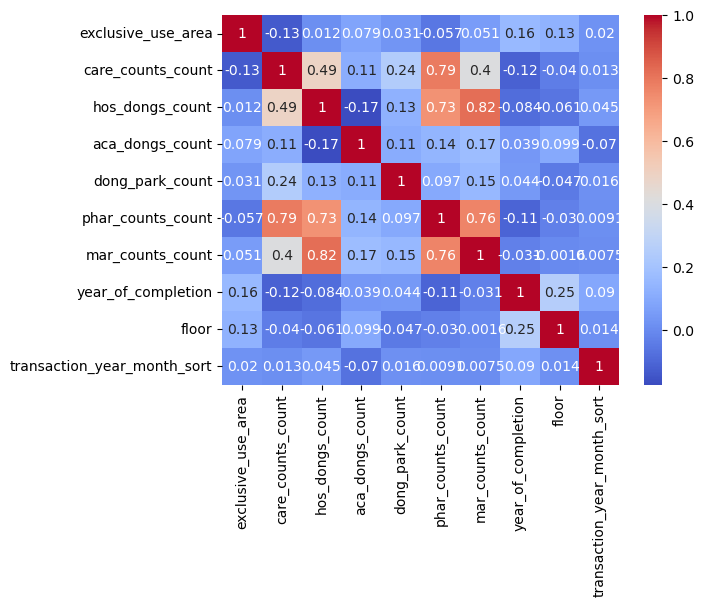

In [26]:
numeric_cols = numeric_features + int_features
numeric_df = train_df[numeric_cols]
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

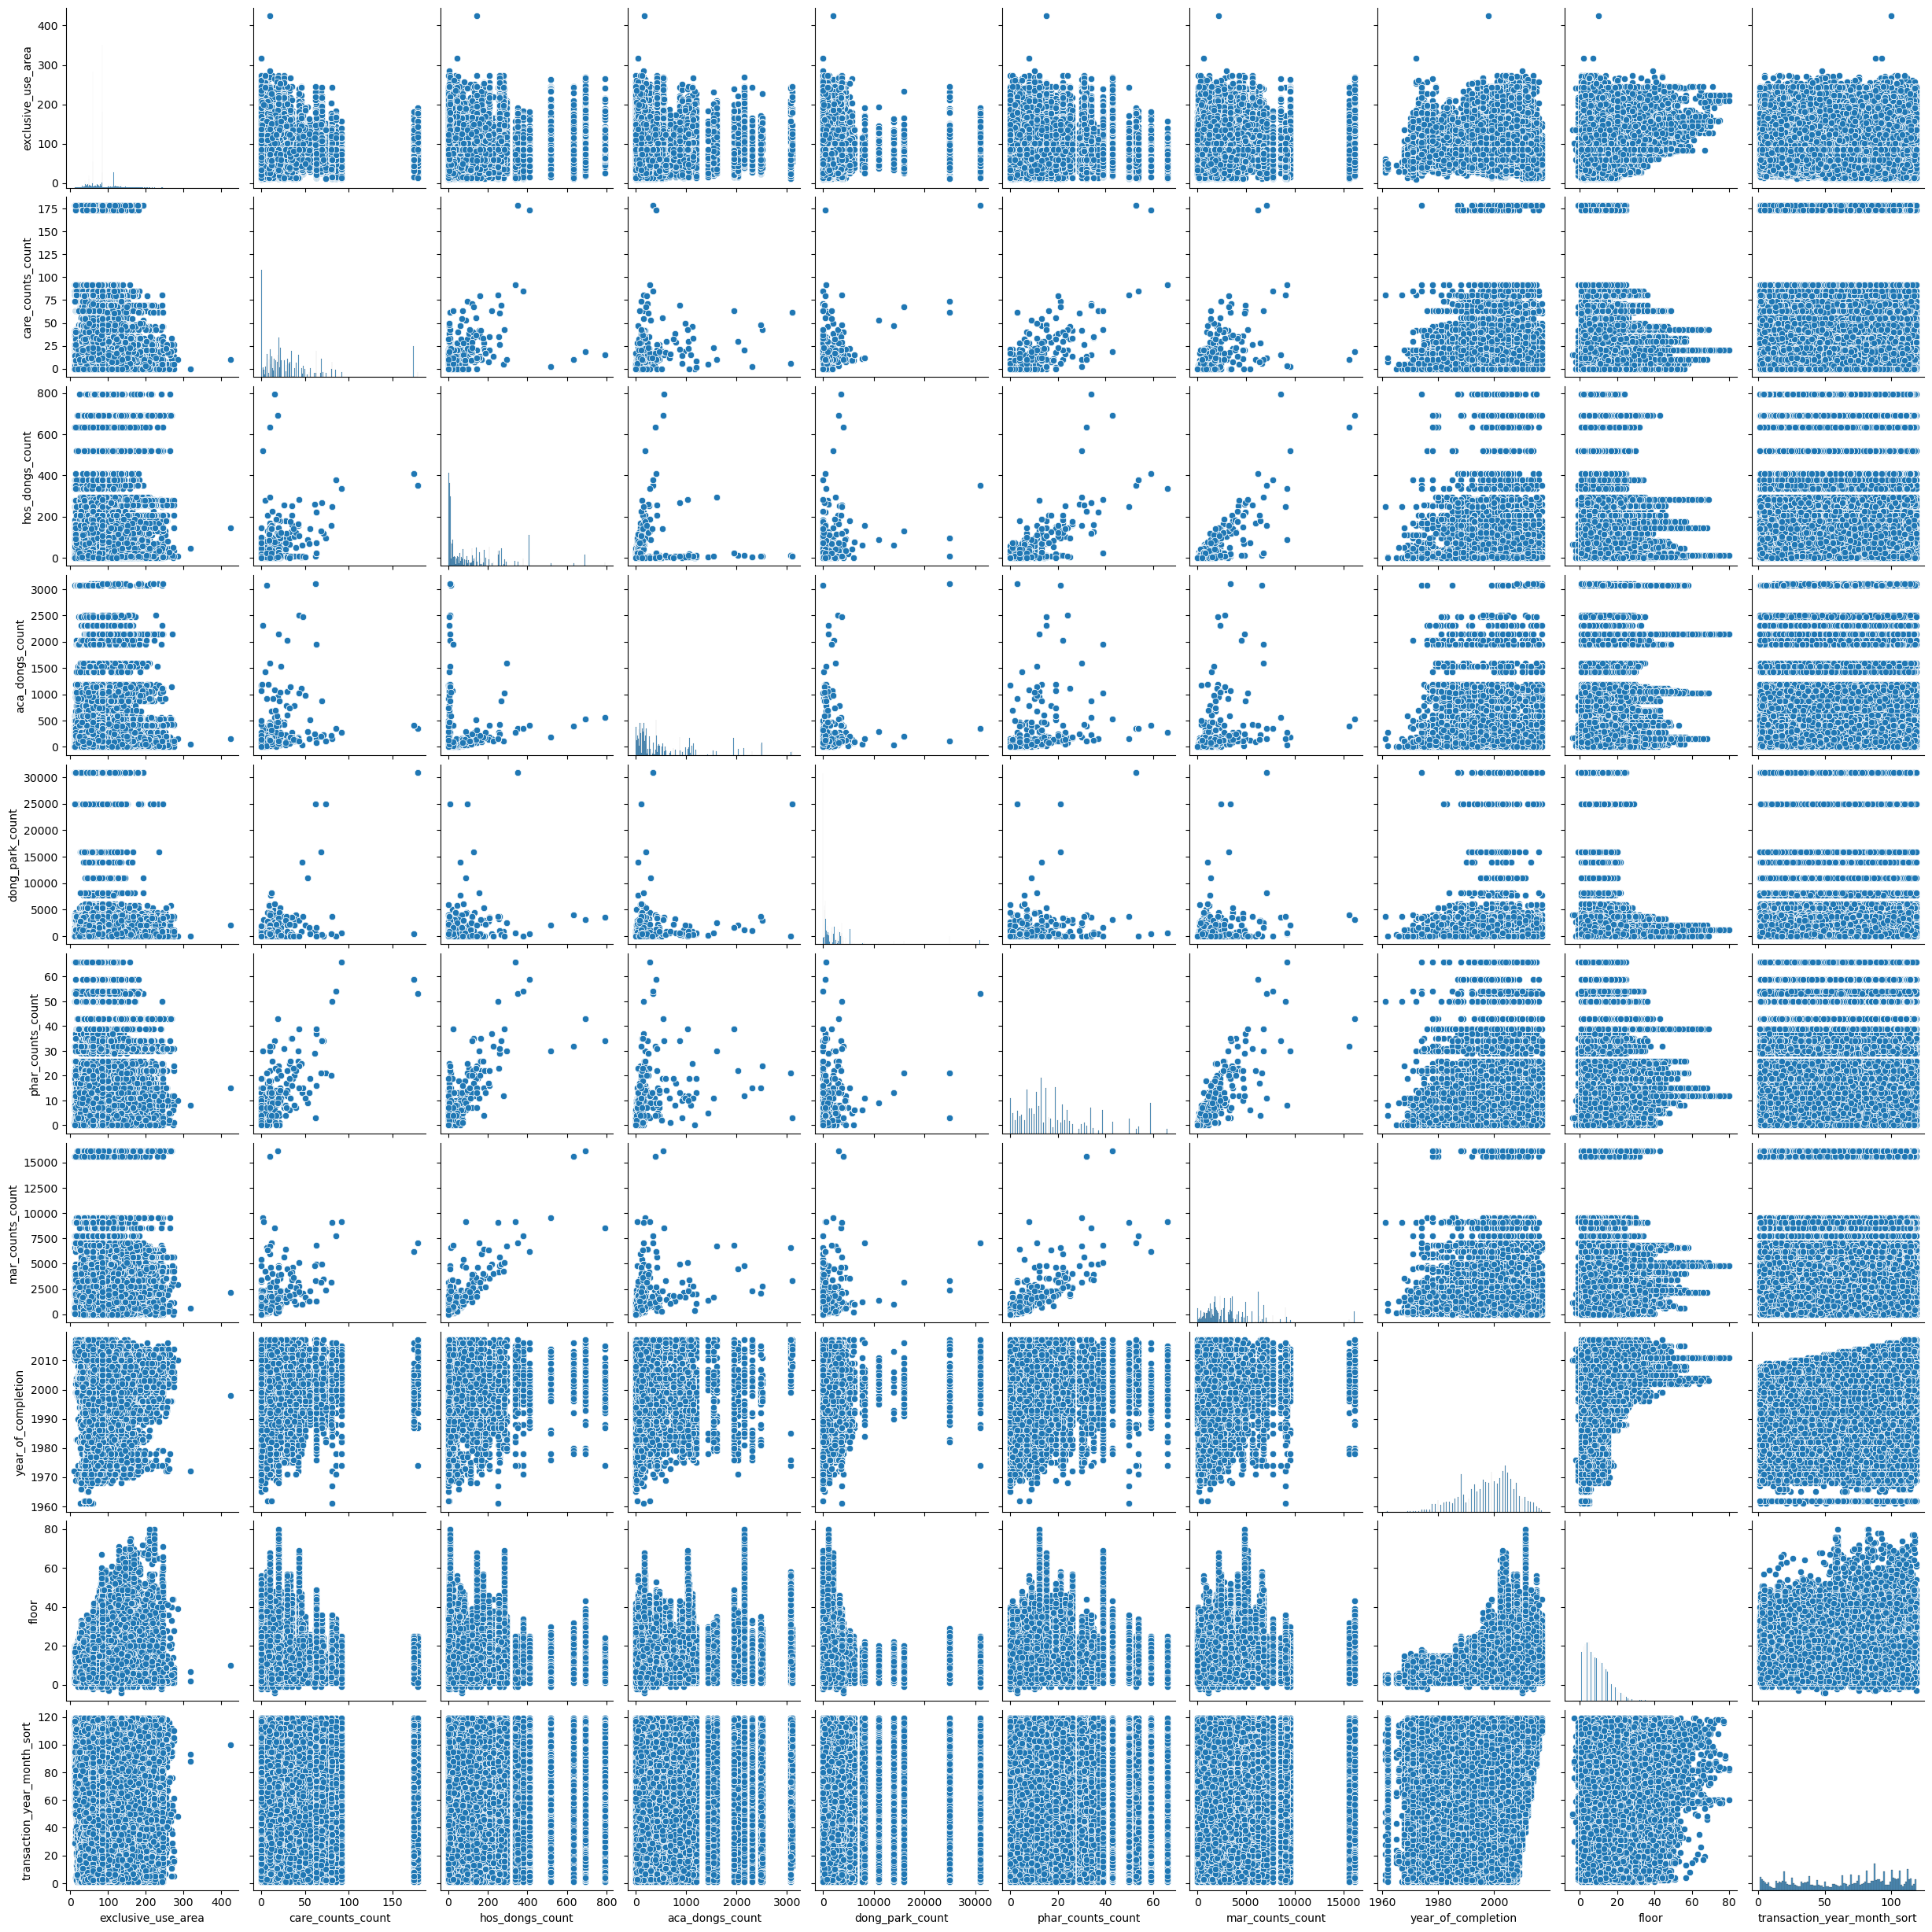

In [27]:
numeric_cols = numeric_features + int_features
numeric_df = train_df[numeric_cols]
sns.pairplot(numeric_df)
plt.show()

In [ ]:
scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)

print("Default LM CV scores: ", np.sqrt(-1*scores))
print("Default LM CV mean = %.2f" % np.sqrt(-1*scores.mean()), "with std = %.2f" % np.sqrt(scores.std()))

Default LM CV scores:  [4557.388292   4572.13748167 4521.79383779 4609.060137   4621.11056007]
Default LM CV mean = 4576.44 with std = 572.63


In [ ]:
model.fit(X,y)
pred_y = model.predict(test_df)
LM_VERSION = 'D&A_ExtraTrees'
# submission 화일 생성
filename = f'LM_{LM_VERSION}_{np.sqrt(-1*scores.mean()):.2f}.csv'
pd.DataFrame({'transaction_id':test_id, 'transaction_real_price':pred_y}).to_csv(filename, index=False)